In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors


In [ ]:
## Load Data

df_complete = pd.read_excel('Planning & Research Analyst Sr_Assessment Data_College Scorecard_Final Data.xlsx')


##Selecting columns to use as comparison

df_filtered = df_complete[['MCC','OPEID6', 'INSTNM', 'LOCALE', 'COSTT4_A', 'PFTFAC', 'C150_L4', 'RET_FTL4']]

# print(df_filtered.head())
# print(df_filtered.columns)
print(df_filtered.isnull().sum())


MCC           0
OPEID6        0
INSTNM        0
LOCALE        0
COSTT4_A    289
PFTFAC      320
C150_L4      96
RET_FTL4    104
dtype: int64


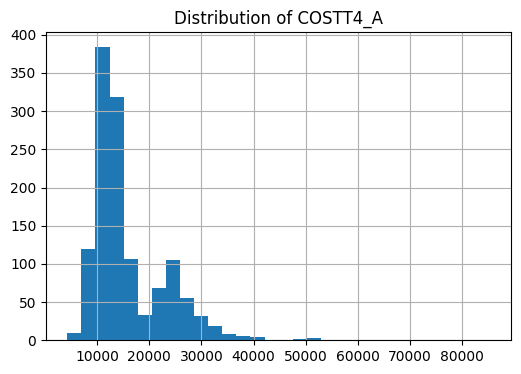

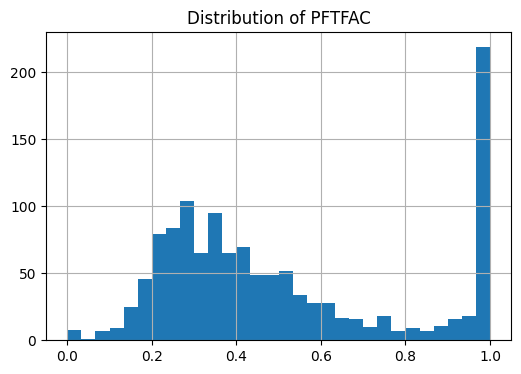

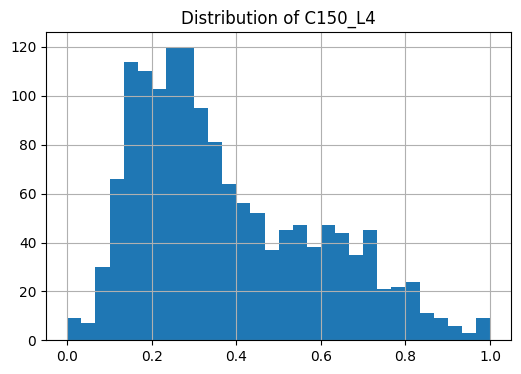

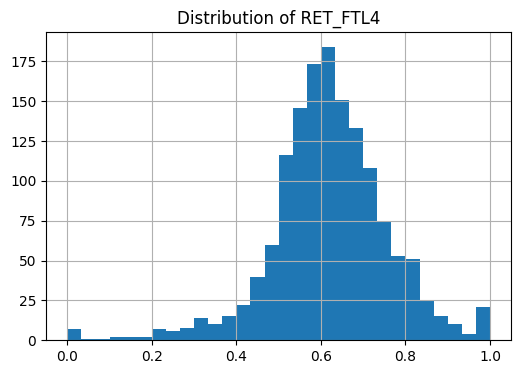

COSTT4_A    0
PFTFAC      0
C150_L4     0
RET_FTL4    0
dtype: int64


In [32]:
## Replace null values

# Determine if mean or median is better

fields = ['COSTT4_A', 'PFTFAC', 'C150_L4', 'RET_FTL4']
for col in fields:
    plt.figure(figsize=(6,4))
    df_filtered[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

val_replacement = df_filtered[fields].copy()
val_replacement['COSTT4_A'] = val_replacement['COSTT4_A'].fillna(val_replacement['COSTT4_A'].median())
val_replacement['PFTFAC'] = val_replacement['PFTFAC'].fillna(val_replacement['PFTFAC'].median())
val_replacement['C150_L4'] = val_replacement['C150_L4'].fillna(val_replacement['C150_L4'].mean())
val_replacement['RET_FTL4'] = val_replacement['RET_FTL4'].fillna(val_replacement['RET_FTL4'].mean())

print(val_replacement.isnull().sum())

In [145]:
## Scale Data
X = val_replacement

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [146]:
## Create Clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df_filtered['clusters'] = clusters

C:\Users\Josef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josef\AppData\Local\Temp\ipykernel_21444\4081733656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['clusters'] = clusters


In [147]:
## Set up 2D plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
df_filtered['PCA1'] = X_pca[:, 0]
df_filtered['PCA2'] = X_pca[:, 1]

C:\Users\Josef\AppData\Local\Temp\ipykernel_21444\3318371284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA1'] = X_pca[:, 0]
C:\Users\Josef\AppData\Local\Temp\ipykernel_21444\3318371284.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PCA2'] = X_pca[:, 1]


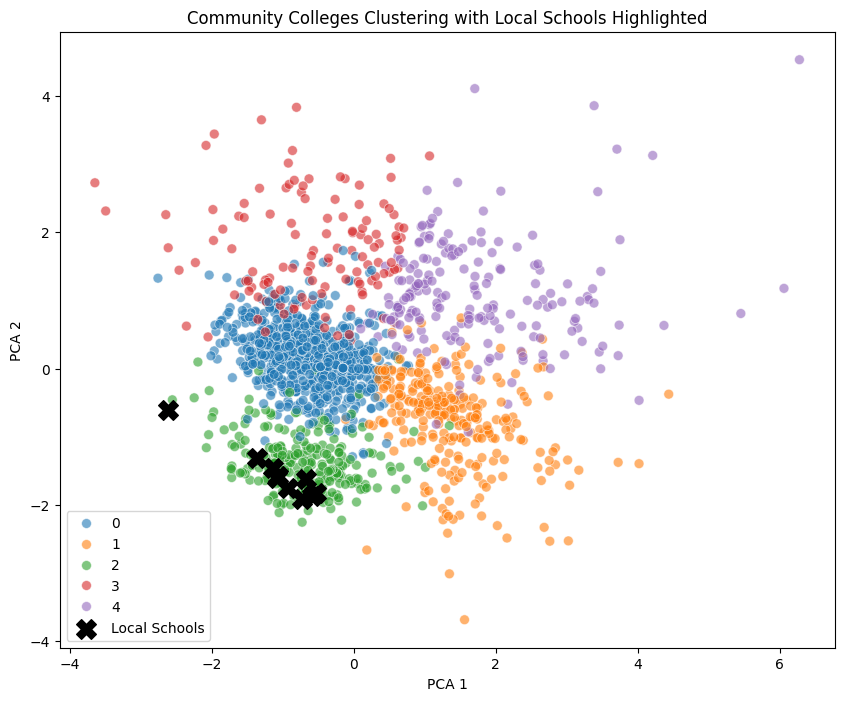

In [148]:
## Plot clusters and determine that MMCCD schools are already similar

local_schools_id = [1076, 8303, 1077, 1078, 21775, 8304, 21466, 26236, 30722, 31563]

# Mark local schools in the plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_filtered, x='PCA1', y='PCA2', hue='clusters', palette='tab10', s=50, alpha=0.6)

# Overlay local schools
local_df = df_filtered[df_filtered['OPEID6'].isin(local_schools_id)]
plt.scatter(local_df['PCA1'], local_df['PCA2'], color='black', s=200, marker='X', label='Local Schools')

plt.title('Community Colleges Clustering with Local Schools Highlighted')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [133]:
## Set up KNN for Top 10 similar schools

## Find the nearest 5 schools and then pick the closest value
knn = NearestNeighbors(n_neighbors=2)
knn.fit(X_scaled)
all_school = df_filtered['INSTNM'].index.tolist()
az_school_names = df_filtered[df_filtered['MCC'].isin(['Y'])]['INSTNM'].to_list()
local_schools_indices = df_filtered[df_filtered['INSTNM'].isin(az_school_names)].index.tolist()

distances, indices = knn.kneighbors(X_scaled[local_schools_indices])


In [180]:
# Define a distance threshold to filter schools by closeness
distance_threshold = 2.0  # Example threshold

# Loop through each local school and print the closest schools that meet the threshold
for i, (dist, idx) in enumerate(zip(distances, indices)):
    local_school_name = local_schools_indices[i]  
    try:
        print(f"\nLocal School: {az_school_names[i]}")
        for j, (d, index) in enumerate(zip(dist, idx)):
            if j != 0 and d <= distance_threshold: 
                closest_school_name = df_filtered.iloc[index]['INSTNM']
                print(f"  - {closest_school_name} (Distance: {d:.2f})")
    except:
        print()



Local School: Glendale Community College
  - Camden County College (Distance: 0.14)

Local School: GateWay Community College
  - Stone Child College (Distance: 0.16)

Local School: Mesa Community College
  - Phoenix College (Distance: 0.03)

Local School: Phoenix College
  - Mesa Community College (Distance: 0.03)

Local School: Rio Salado College
  - Cankdeska Cikana Community College (Distance: 0.28)

Local School: Scottsdale Community College
  - Northeast Texas Community College (Distance: 0.08)

Local School: South Mountain Community College
  - Trinity Valley Community College (Distance: 0.12)

Local School: Paradise Valley Community College
  - Allan Hancock College (Distance: 0.18)

Local School: Chandler-Gilbert Community College
  - Chandler-Gilbert Community College (Distance: 0.16)

Local School: Estrella Mountain Community College
  - Paradise Valley Community College (Distance: 0.16)



In [166]:
## Cost and Retention K-means

C_R_replacement = val_replacement[['C150_L4', 'RET_FTL4']]
C_R_replacement

X_2 = C_R_replacement

scaler = StandardScaler()
X_scaled_2 = scaler.fit_transform(X_2)

## Create Clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_2 = kmeans.fit_predict(X_scaled_2)
df_filtered_2 = df_filtered
df_filtered_2['clusters'] = clusters_2

## Set up 2D plotting
pca_2 = PCA(n_components=2)
X_pca_2 = pca.fit_transform(X_scaled_2)

# Add PCA components to dataframe
df_filtered_2['PCA1'] = X_pca_2[:, 0]
df_filtered_2['PCA2'] = X_pca_2[:, 1]

C:\Users\Josef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josef\AppData\Local\Temp\ipykernel_21444\109298413.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2['clusters'] = clusters_2
C:\Users\Josef\AppData\Local\Temp\ipykernel_21444\109298413.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

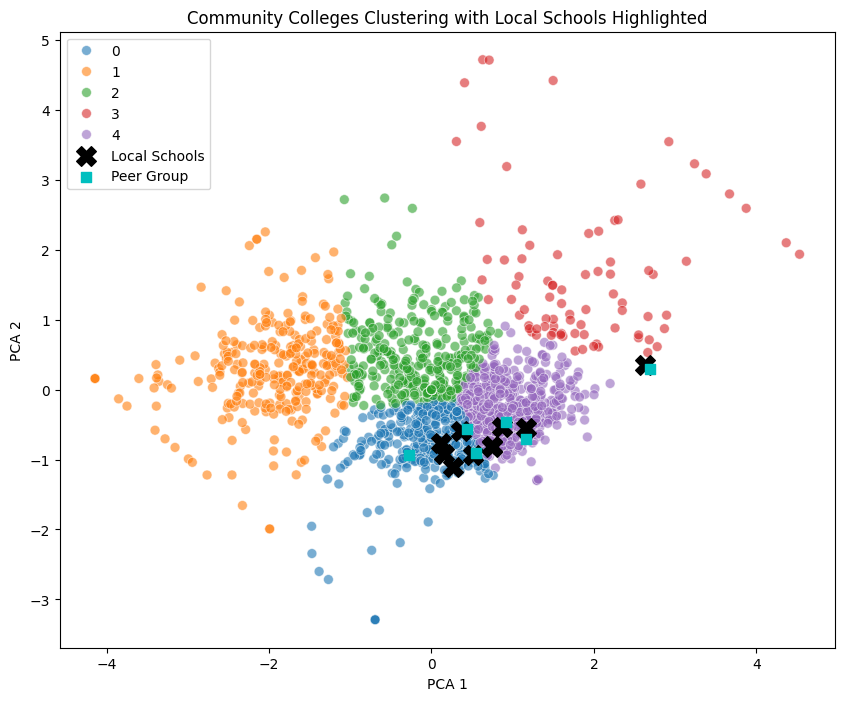

In [171]:
## Plot clusters and determine that MMCCD schools are already similar

local_schools_id = [1076, 8303, 1077, 1078, 21775, 8304, 21466, 26236, 30722, 31563]

peer_group_id = [6865, 26109, 22365, 23154, 3572, 1111]
# Mark local schools in the plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_filtered, x='PCA1', y='PCA2', hue='clusters', palette='tab10', s=50, alpha=0.6)

# Overlay local schools
local_df_2 = df_filtered_2[df_filtered_2['OPEID6'].isin(local_schools_id)]
plt.scatter(local_df_2['PCA1'], local_df_2['PCA2'], color='black', s=200, marker='X', label='Local Schools')

# Overlay peer schools
local_df_2 = df_filtered_2[df_filtered_2['OPEID6'].isin(peer_group_id)]
plt.scatter(local_df_2['PCA1'], local_df_2['PCA2'], color='c', s=50, marker='s', label='Peer Group')

plt.title('Community Colleges Clustering with Local Schools Highlighted')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [179]:
df_filtered_2[df_filtered_2['MCC'] == 'Y']

,MCC,OPEID6,INSTNM,LOCALE,COSTT4_A,PFTFAC,C150_L4,RET_FTL4,clusters,PCA1,PCA2
32,Y,1076,Glendale Community College,21,11400.0,1.0,0.1653,0.6596,0,0.515170,-0.941074
33,Y,8303,GateWay Community College,11,12293.0,1.0,0.1287,0.5597,4,1.163487,-0.545230
34,Y,1077,Mesa Community College,11,11943.0,1.0,0.1514,0.6244,4,0.747068,-0.805060
37,Y,1078,Phoenix College,11,11775.0,1.0,0.1487,0.6264,4,0.745929,-0.824825
41,Y,21775,Rio Salado College,12,10678.0,1.0,0.0465,0.3333,3,2.630176,0.354428
42,Y,8304,Scottsdale Community College,41,12375.0,1.0,0.2372,0.6413,0,0.362816,-0.597448
43,Y,21466,South Mountain Community College,11,11801.0,1.0,0.1731,0.5878,4,0.863496,-0.538942
1105,Y,26236,Paradise Valley Community College,11,11618.0,1.0,0.2205,0.6927,0,0.151798,-0.923666
1106,Y,30722,Chandler-Gilbert Community College,21,11744.0,1.0,0.2482,0.6804,0,0.120538,-0.763846
1160,Y,31563,Estrella Mountain Community College,22,11349.0,1.0,0.1778,0.6992,0,0.265105,-1.104911


In [178]:
completion_avg = df_filtered_2[df_filtered_2['MCC'] == 'Y']['C150_L4'].mean()
completion_avg_2 = df_filtered_2[df_filtered_2['MCC'] == 'N']['C150_L4'].mean()
print('MCCC avg:', completion_avg *100 , 'Others:', completion_avg_2 *100)

ret_avg = df_filtered_2[df_filtered_2['MCC'] == 'Y']['RET_FTL4'].mean()
ret_avg_2 = df_filtered_2[df_filtered_2['MCC'] == 'N']['RET_FTL4'].mean()
print('MCCC avg:', ret_avg * 100, 'Others:', ret_avg_2 *100)

MCCC avg: 16.974 Others: 37.782089041095894
MCCC avg: 61.04799999999999 Others: 61.890929752066114
